In [1]:
import os
import cv2
import random
import pandas as pd
import numpy as np
from tqdm import tqdm
import albumentations as A
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold, train_test_split
from typing import Tuple, List, Sequence, Callable

import timm
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch_optimizer as optim
import torchvision.transforms as tfms
from torchinfo import summary
from torch.utils.data import DataLoader, Dataset
import gc
import warnings
warnings.filterwarnings('ignore')
gc.collect()
torch.cuda.empty_cache()

In [2]:
main_dir='./data/'
train_img_path = os.path.join(main_dir, 'train_imgs')
test_img_path = os.path.join(main_dir, 'test_imgs')
meta_info_dir = os.path.join(main_dir, 'train_df.csv')

In [3]:
from glob import glob
train_df = pd.read_csv(meta_info_dir)
print(train_df.shape)
temp = glob('./data/train_imgs/*.jpg')
print(len(train_df))
print(len(temp))



(4174, 50)
4174
4174


In [4]:
from typing import List


class SingleModelConfig:
  def __init__(self,
               input_size: List[int] = [384, 288],
               epochs: int = 30,
               batch_size: int = 8,
               random_seed: int = 1997,
               test_ratio: float = 0.3,
               learning_rate: float = 1e-3,
               num_joints: int = 24,
               sigma: float = 3.0,
               main_dir: str = main_dir,
               extract: str = 'pose_fix',
               loss_type: str = "OHKMMSE",
               target_type: str = "gaussian",
               post_processing: str = "dark",
               mode: str = "train",
               save_folder: str = 'single_hrdnet_w48_384x288_sectorBase_startify',
               shift: bool = False,
               udp: bool = False,
               debug: bool = False,
               startify: bool = False,
               init_training: bool = False
               ):

    self.main_dir = main_dir
    self.epochs = epochs
    self.batch_size = batch_size
    self.seed = random_seed
    self.lr = learning_rate
    self.startify = startify
    self.test_ratio = test_ratio
    self.image_size = np.array(input_size)
    self.output_size = self.image_size//4
    self.mode = mode
    self.extract = extract
    self.shift = shift
    self.debug = debug
    self.udp = udp
    self.num_joints = num_joints
    self.sigma = sigma
    self.target_type = target_type
    self.init_training = init_training
    self.post_processing = post_processing
    self.loss_type = loss_type

    self.save_folder = os.path.join(main_dir, save_folder)
    if not os.path.exists(self.save_folder):
      os.makedirs(self.save_folder, exist_ok=True)

    self.joints_name = {
        0: 'nose', 1: 'left_eye', 2: 'right_eye', 3: 'left_ear', 4: 'right_ear',
        5: 'left_shoulder', 6: 'right_shoulder', 7: 'left_elbow', 8: 'right_elbow',
        9: 'left_wrist', 10: 'right_wrist', 11: 'left_hip', 12: 'right_hip',
        13: 'left_knee', 14: 'right_knee', 15: 'left_ankle', 16: 'right_ankle',
        17: 'neck', 18: 'left_palm', 19: 'right_palm', 20: 'back_spine', 21: 'waist_spine',
        22: 'left_instep', 23: 'right_instep'
    }

    self.joint_pair = [
        (0, 1), (0, 2), (2, 4), (1, 3), (6, 8), (8, 10),
        (5, 7), (7, 9), (11, 13), (13, 15), (12, 14),
        (14, 16), (5, 6), (15, 22), (16, 23), (11, 21),
        (21, 12), (20, 21), (5, 20), (6, 20), (17, 6), (17, 5)
    ]

    self.flip_pair = [
        (1, 2), (3, 4), (5, 6), (7, 8),
        (9, 10), (11, 12), (13, 14), (15, 16),
        (18, 19), (22, 23)
    ]

    self.joint_colors = {
        k: tuple(map(int, np.random.randint(0, 255, 3))) for k in range(24)}


In [5]:
cfg = SingleModelConfig()


In [6]:
def show_image(cfg, image, keypoints, factor=None):
    if keypoints.shape[-1] == 3:
      keypoints = keypoints[:,:2].astype(np.int)
    keypoints = keypoints[:, :2].astype(np.int)
    image=cv2.imread(image,cv2.IMREAD_COLOR)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    colors = cfg.joint_colors

    if factor is not None:
      keypoints[:, 0] = keypoints[:, 0] * factor[0]
      keypoints[:, 1] = keypoints[:, 1] * factor[1]

    x1, y1 = int(min(keypoints[:, 0])), int(min(keypoints[:, 1]))
    x2, y2 = int(max(keypoints[:, 0])), int(max(keypoints[:, 1]))
    
    keypoints[:, 0] -= 500
    keypoints[:, 1] -= 150
    image=image[150:900,500:1400,:]
   
    

    for i, pair in enumerate(cfg.joint_pair):
        cv2.line(
            image,
            tuple(keypoints[pair[0]]),
            tuple(keypoints[pair[1]]),
            colors.get(pair[0]), 1, lineType=cv2.LINE_AA)
    for i, keypoint in enumerate(keypoints):
        temp = np.random.randint(255)
        temp1 = np.random.randint(255)
        temp2 = np.random.randint(255)
        cv2.circle(
            image,
            tuple(keypoint),
            3, colors.get(i), thickness=3, lineType=cv2.FILLED)

        cv2.putText(
            image,
            #f'{i}: {cfg.joints_name[i]}',
            f'{i}',
            tuple(keypoint),
          
            cv2.FONT_HERSHEY_SIMPLEX, 1, (temp1, temp2, temp), 2)


    fig, ax = plt.subplots(dpi=500)
    ax.imshow(image)
    ax.axis('off')
    plt.show()

# index = sorted(glob('./data/train_imgs/*.jpg'))
# indice=[317, 869, 873, 911, 1559, 1560, 1562, 1575, 1577, 1578, 1582, 1606, 1622, 1623, 1624, 1625, 1629, 3968]
# for i in indice:
#   image = index[i]
#   print(image)
#   keypoints = train_df.iloc[i,1:].values
#   keypoints=keypoints.reshape(24,2)
#   show_image(cfg,image,keypoints,factor=None)


In [7]:
import math
def get_affine_transform(center,
                         scale,
                         rot,
                         output_size,
                         shift=np.array([0, 0], dtype=np.float32),
                         inv=0,):
    if not isinstance(scale, np.ndarray) and not isinstance(scale, list):
        print(scale)
        scale = np.array([scale, scale])

    src_w = scale[0]
    dst_w = output_size[0]
    dst_h = output_size[1]

    rot_rad = np.pi * rot / 180
    src_dir = get_dir([0, src_w * -0.5], rot_rad)
    dst_dir = np.array([0, dst_w * -0.5], np.float32)

    src = np.zeros((3, 2), dtype=np.float32)
    dst = np.zeros((3, 2), dtype=np.float32)
    src[0, :] = center + scale * shift
    src[1, :] = center + src_dir + scale * shift
    dst[0, :] = [dst_w * 0.5, dst_h * 0.5]
    dst[1, :] = np.array([dst_w * 0.5, dst_h * 0.5]) + dst_dir

    src[2:, :] = get_3rd_point(src[0, :], src[1, :])
    dst[2:, :] = get_3rd_point(dst[0, :], dst[1, :])

    if inv:
        trans = cv2.getAffineTransform(np.float32(dst), np.float32(src))
    else:
        trans = cv2.getAffineTransform(np.float32(src), np.float32(dst))

    return trans


# 실제 어파인 변환 수행하는 부분
# t는 위의 get_affine_transform 함수를 통해 trans 매트릭스 구한다.
def affine_transform(pt, t):
    new_pt = np.array([pt[0], pt[1], 1.]).T
    new_pt = np.dot(t, new_pt)
    return new_pt[:2]


# TODO: 뭐하는 함수지?
def get_dir(src_point, rot_rad):
    """ 
        Transformation Matrix 
        x = x * cosΘ - y * sinΘ
        y = x * cosΘ + y * sinΘ
        [ cosΘ   sinΘ   0]
        [ -sinΘ  cosΘ   0]
        [  0       0    0]
    """

    sn, cs = np.sin(rot_rad), np.cos(rot_rad)

    src_result = [0, 0]
    src_result[0] = src_point[0] * cs - src_point[1] * sn
    src_result[1] = src_point[0] * sn + src_point[1] * cs

    return src_result


def get_3rd_point(a, b):
    direct = a - b
    return b + np.array([-direct[1], direct[0]], dtype=np.float32)


def shift_images(image, keypoints, max_v=5, max_h=5):
    tmp_keypoints = np.ones_like(keypoints)
    shift_v = np.random.randint(low=-max_v, high=max_v)
    shift_h = np.random.randint(low=-max_h, high=max_h)

    m = np.float32([
        [1, 0, shift_h],
        [0, 1, shift_v],
    ])

    rows, cols = image.shape[:-1]
    image = cv2.warpAffine(image, m, (cols, rows))

    # tmp_keypoints[:, 0] = keypoints[:, 0] + shift_v/cols
    # tmp_keypoints[:, 1] = keypoints[:, 1] + shift_h/rows
    for j in range(len(keypoints)):
        keypoints[j, :2] = affine_transform(keypoints[j, :2], m)

    return image, keypoints
## UDP
## https://github.com/HuangJunJie2017/UDP-Pose/blob/master/deep-high-resolution-net.pytorch/lib/dataset/JointsDataset.py


def get_warpmatrix(theta, size_input, size_dst, size_target):
    '''
    :param theta: angle
    :param size_input:[w,h]
    :param size_dst: [w,h]
    :param size_target: [w,h]/200.0
    :return:
    '''
    size_target = size_target * 200.0
    theta = theta / 180.0 * math.pi
    matrix = np.zeros((2, 3), dtype=np.float32)
    scale_x = size_target[0]/size_dst[0]
    scale_y = size_target[1]/size_dst[1]
    matrix[0, 0] = math.cos(theta) * scale_x
    matrix[0, 1] = math.sin(theta) * scale_y
    matrix[0, 2] = -0.5 * size_target[0] * \
        math.cos(theta) - 0.5 * size_target[1] * \
        math.sin(theta) + 0.5 * size_input[0]
    matrix[1, 0] = -math.sin(theta) * scale_x
    matrix[1, 1] = math.cos(theta) * scale_y
    matrix[1, 2] = 0.5*size_target[0] * \
        math.sin(theta)-0.5*size_target[1]*math.cos(theta)+0.5*size_input[1]
    return matrix


def rotate_points(src_points, angle, c, dst_img_shape, size_target, do_clip=True):
    # src_points: (num_points, 2)
    # img_shape: [h, w, c]
    size_target = size_target * 200.0
    src_img_center = c
    scale_x = (dst_img_shape[0]-1.0)/size_target[0]
    scale_y = (dst_img_shape[1]-1.0)/size_target[1]
    radian = angle / 180.0 * math.pi
    radian_sin = -math.sin(radian)
    radian_cos = math.cos(radian)
    dst_points = np.zeros(src_points.shape, dtype=src_points.dtype)
    src_x = src_points[:, 0] - src_img_center[0]
    src_y = src_points[:, 1] - src_img_center[1]
    dst_points[:, 0] = radian_cos * src_x + radian_sin * src_y
    dst_points[:, 1] = -radian_sin * src_x + radian_cos * src_y
    dst_points[:, 0] += size_target[0]*0.5
    dst_points[:, 1] += size_target[1]*0.5
    dst_points[:, 0] *= scale_x
    dst_points[:, 1] *= scale_y
    if do_clip:
        # if dst_points[:, 0] < 0 or dst_points[:, 0] >= dst_img_shape[1]: dst_points[:, 2] = 0
        # if dst_points[:, 1] < 0 or dst_points[:, 1] >= dst_img_shape[0]: dst_points[:, 2] = 0

        dst_points[:, 0] = np.clip(dst_points[:, 0], 0, dst_img_shape[1] - 1)
        dst_points[:, 1] = np.clip(dst_points[:, 1], 0, dst_img_shape[0] - 1)
    return dst_points


In [8]:
class DaconKeypointsDataset(Dataset):
    def __init__(
        self,
        image_dir,
        label_df,
        transforms=None,
        cfg=cfg
    ) -> None:
        self.image_dir = image_dir
        self.df = label_df
        self.transforms = transforms

        self.udp = cfg.udp
        self.mode = cfg.mode
        self.debug = cfg.debug
        self.shift = cfg.shift
        self.num_joints = cfg.num_joints
        self.flip_pairs = cfg.flip_pair
        self.image_size = cfg.image_size
        self.heatmap_size = cfg.output_size
        self.sigma = cfg.sigma
        self.target_type = cfg.target_type

    def __len__(self) -> int:
        return self.df.shape[0]

    def __getitem__(self, index: int):
        image_id = self.df.iloc[index, 0]
        labels = np.array([1])
        keypoints = self.df.iloc[index,
                                 1:].values.reshape(-1, 2).astype(np.float32)
        keypoints = np.concatenate([keypoints,  np.ones((24, 1))], axis=1)

        # define bbox
        xmin = np.min(keypoints[:, 0])
        xmax = np.max(keypoints[:, 0])
        width = xmax - xmin if xmax > xmin else 20
        center = (xmin + xmax)/2.
        xmin = int(center - width/2.*1.2)
        xmax = int(center + width/2.*1.2)

        ymin = np.min(keypoints[:, 1])
        ymax = np.max(keypoints[:, 1])
        height = ymax - ymin if ymax > ymin else 20
        center = (ymin + ymax)/2.
        ymin = int(center - height/2.*1.2)
        ymax = int(center + height/2.*1.2)

        x, y, w, h = xmin, ymin, xmax-xmin, ymax-ymin
        aspect_ratio = self.image_size[1] / self.image_size[0]
        centre = np.array([x+w*.5, y+h*.5])
        if w > aspect_ratio * h:
            h = w * 1.0 / aspect_ratio
        elif w < aspect_ratio * h:
            w = h * aspect_ratio


       #-------------------------------------------------------------------
        scale = np.array([w, h]) * 1.25
        rotation = 0

        image = cv2.imread(os.path.join( self.image_dir, image_id), cv2.COLOR_BGR2RGB)
        if self.mode == 'train':
            scale_factor = 0.3
            rotate_factor = 45
            scale = scale * \
                np.clip(np.random.randn()*scale_factor +
                        1, 1-scale_factor, 1+scale_factor)
            rotation = np.clip(np.random.randn()*rotate_factor, -rotate_factor*2,
                               rotate_factor*2) if random.random() <= 0.5 else 0

            # lr flipping
            if np.random.random() <= 0.5:
              image = np.flip(image, 1)
              centre[0] = image.shape[1] - 1 - centre[0]

              keypoints[:, 0] = image.shape[1] - 1 - keypoints[:, 0]
              for (q, w) in self.flip_pairs:
                  keypoints_q, keypoints_w = keypoints[q, :].copy(
                  ), keypoints[w, :].copy()
                  keypoints[w, :], keypoints[q, :] = keypoints_q, keypoints_w

            # if self.transforms is not None:
            #   image = self.transforms(image=image)['image']

        
        trans = get_affine_transform(
            centre, scale, rotation, (self.image_size[1], self.image_size[0]))
        cropped_image = cv2.warpAffine(
            image, trans, (self.image_size[1], self.image_size[0]), flags=cv2.INTER_LINEAR)
        #print(f'affine트랜스폼후 이미지 : {cropped_image.shape}')      
        for j in range(self.num_joints):
            if keypoints[j, 2] > 0:
                keypoints[j, :2] = affine_transform(keypoints[j, :2], trans)
                keypoints[j, 2] *= ((keypoints[j, 0] >= 0) & (keypoints[j, 0] < self.image_size[1])
                                    & (keypoints[j, 1] >= 0) & (keypoints[j, 1] < self.image_size[0]))

        target, target_weight = self.generate_target(
            keypoints[:, :2], keypoints[:, 2])
        target = torch.from_numpy(target)
        target_weight = torch.from_numpy(target_weight)
        if self.transforms is not None:
            cropped_image = self.transforms(image=cropped_image)['image']
       # print(f'트랜스폼전 이미지 : {cropped_image.shape}')

        # random horizontal & vertical shifting
        if self.mode == 'train' and self.shift and np.random.random() <= 0.5:
            cropped_image, keypoints = shift_images(cropped_image, keypoints)
        #print(f'입력직전 이미지 : {cropped_image.shape}')
        sample = {
            'image': torch.from_numpy(cropped_image).float().permute(2, 0, 1),
            'keypoints': torch.from_numpy(keypoints).float(),
            'target': target,
            'target_weight': target_weight
        }
        return sample

    def render_gaussian_heatmap(self, coord, valid=None):
        """
            Render gaussian heatmap
            
            [Args]
                [coord]: coords for gaussian rendering
                
                [output_shape]: output heatmap shape
                
                [sigma]: gaussian sigma
        """

        x = [i for i in range(self.heatmap_size[1])]
        y = [i for i in range(self.heatmap_size[0])]
        xx, yy = np.meshgrid(x, y)

        if isinstance(coord, np.ndarray):
          xx = np.reshape(xx, (1, *self.heatmap_size, 1))
          yy = np.reshape(yy, (1, *self.heatmap_size, 1))

          x = np.reshape(coord[:, 0], [-1, 1, 1, self.num_joints]
                         ) / self.image_size[1] * self.heatmap_size[1]
          y = np.reshape(coord[:, 1], [-1, 1, 1, self.num_joints]
                         ) / self.image_size[0] * self.heatmap_size[0]

          heatmap = np.exp(-(((xx-x)/self.sigma)**2) /
                           2.0 - (((yy-y)/self.sigma)**2)/2.0)
          return heatmap * 255.
          # return heatmap
        elif isinstance(coord, torch.Tensor):
          xx = torch.from_numpy(xx)
          yy = torch.from_numpy(yy)
          xx = torch.reshape(xx.float(), (1, *self.heatmap_size, 1))
          yy = torch.reshape(yy.float(), (1, *self.heatmap_size, 1))

          x = torch.reshape(coord[:, :, 0], [-1, 1, 1, self.num_joints]
                            ) / self.image_size[1] * self.heatmap_size[1]
          y = torch.reshape(coord[:, :, 1], [-1, 1, 1, self.num_joints]
                            ) / self.image_size[0] * self.heatmap_size[0]

          heatmap = torch.exp(-(((xx-x)/torch.tensor(self.sigma, dtype=torch.float))**2) /
                              2.0 - (((yy-y)/torch.tensor(self.sigma, dtype=torch.float))**2)/2.0)
          if valid is not None:
              valid_mask = torch.reshape(valid, [-1, 1, 1, self.num_joints])
              heatmap = heatmap * valid_mask
          return (heatmap*255.).permute(0, 3, 1, 2)
          # return heatmap.permute(0,3,1,2)

    def generate_target(self, joints, joints_vis):
        '''
        :param joints:  [num_joints, 3]
        :param joints_vis: [num_joints, 3]
        :return: target, target_weight(1: visible, 0: invisible)
        '''
        target_weight = np.ones((self.num_joints, 1), dtype=np.float32)
        target_weight[:, 0] = joints_vis

        assert self.target_type == 'gaussian', \
            'Only support gaussian map now!'

        if self.target_type == 'gaussian':
            target = np.zeros((self.num_joints,
                               self.heatmap_size[0],
                               self.heatmap_size[1]),
                              dtype=np.float32)
            tmp_size = self.sigma * 3

            for joint_id in range(self.num_joints):
                feat_stride = self.image_size / self.heatmap_size
                mu_x = int(joints[joint_id][0] / feat_stride[0] + 0.5)
                mu_y = int(joints[joint_id][1] / feat_stride[1] + 0.5)
                # Check that any part of the gaussian is in-bounds
                ul = [int(mu_x - tmp_size), int(mu_y - tmp_size)]
                br = [int(mu_x + tmp_size + 1), int(mu_y + tmp_size + 1)]
                if ul[0] >= self.heatmap_size[0] or ul[1] >= self.heatmap_size[1] \
                        or br[0] < 0 or br[1] < 0:
                    # If not, just return the image as is
                    target_weight[joint_id] = 0
                    continue

                # # Generate gaussian
                size = 2 * tmp_size + 1
                x = np.arange(0, size, 1, np.float32)
                y = x[:, np.newaxis]
                x0 = y0 = size // 2
                # The gaussian is not normalized, we want the center value to equal 1
                g = np.exp(- ((x - x0) ** 2 + (y - y0) ** 2) /
                           (2 * self.sigma ** 2))

                # Usable gaussian range
                g_x = max(0, -ul[0]), min(br[0], self.heatmap_size[1]) - ul[0]
                g_y = max(0, -ul[1]), min(br[1], self.heatmap_size[0]) - ul[1]
                # Image range
                img_x = max(0, ul[0]), min(br[0], self.heatmap_size[1])
                img_y = max(0, ul[1]), min(br[1], self.heatmap_size[0])

                v = target_weight[joint_id]
                if v > 0.5:
                    # plt.imshow(g[g_y[0]:g_y[1], g_x[0]:g_x[1]])
                    # plt.show()

                    target[joint_id][img_y[0]:img_y[1], img_x[0]:img_x[1]] = \
                        g[g_y[0]:g_y[1], g_x[0]:g_x[1]]

        # if self.use_different_joints_weight:
        #     target_weight = np.multiply(target_weight, self.joints_weight)

        return target * 255., target_weight


In [9]:
# https://github.com/leoxiaobin/deep-high-resolution-net.pytorch/blob/master/lib/core/loss.py#L15:7
class JointsRMSELoss(nn.Module):
    def __init__(self, use_target_weight=False):
        super(JointsRMSELoss, self).__init__()
        self.criterion = nn.MSELoss(reduction='none')

    def forward(self, pred, target):
        target_coord = target[:, :, :2]
        valid_mask = target[:, :, 2].unsqueeze(-1)
        loss = self.criterion(pred, target_coord) * valid_mask
        loss = torch.sqrt(torch.mean(torch.mean(loss, dim=-1)))
        return loss


class JointsMSELoss(nn.Module):
    def __init__(self, use_target_weight=True):
        super(JointsMSELoss, self).__init__()
        self.criterion = nn.MSELoss(reduction='mean')
        self.use_target_weight = use_target_weight

    def forward(self, output, target, target_weight):
        batch_size = output.size(0)
        num_joints = output.size(1)
        heatmaps_pred = output.reshape(
            (batch_size, num_joints, -1)).split(1, 1)
        heatmaps_gt = target.reshape((batch_size, num_joints, -1)).split(1, 1)

        loss = 0

        for idx in range(num_joints):
            heatmap_pred = heatmaps_pred[idx].squeeze()
            heatmap_gt = heatmaps_gt[idx].squeeze()

            if self.use_target_weight:
                loss += 0.5 * self.criterion(
                    heatmap_pred.mul(target_weight[:, idx]),
                    heatmap_gt.mul(target_weight[:, idx])
                )
            else:
                loss += 0.5 * self.criterion(heatmap_pred, heatmap_gt)

        return loss / num_joints


class JointsOHKMMSELoss(nn.Module):
    def __init__(self, use_target_weight=True, topk=8):
        super(JointsOHKMMSELoss, self).__init__()
        self.criterion = nn.MSELoss(reduction='none')
        self.use_target_weight = use_target_weight
        self.topk = topk

    def ohkm(self, loss):
        ohkm_loss = 0.
        for i in range(loss.size()[0]):
            sub_loss = loss[i]
            topk_val, topk_idx = torch.topk(
                sub_loss, k=self.topk, dim=0, sorted=False
            )
            tmp_loss = torch.gather(sub_loss, 0, topk_idx)
            ohkm_loss += torch.sum(tmp_loss) / self.topk
        ohkm_loss /= loss.size()[0]
        return ohkm_loss

    def forward(self, output, target, target_weight):
        batch_size = output.size(0)
        num_joints = output.size(1)
        heatmaps_pred = output.reshape(
            (batch_size, num_joints, -1)).split(1, 1)
        heatmaps_gt = target.reshape((batch_size, num_joints, -1)).split(1, 1)

        loss = []
        for idx in range(num_joints):
            heatmap_pred = heatmaps_pred[idx].squeeze()
            heatmap_gt = heatmaps_gt[idx].squeeze()
            if self.use_target_weight:
                loss.append(float(0.5 * self.criterion(
                    heatmap_pred.mul(target_weight[:, idx]),
                    heatmap_gt.mul(target_weight[:, idx])
                )))
            else:
                loss.append(
                    float(0.5 * self.criterion(heatmap_pred, heatmap_gt))
                )

        loss = [l.mean(dim=1).unsqueeze(dim=1) for l in loss]
        loss = torch.cat(loss, dim=1)

        return self.ohkm(loss)


In [10]:
# https://github.com/leoxiaobin/deep-high-resolution-net.pytorch/blob/master/lib/models/pose_hrnet.py
# HRNET

import torch
import torch.nn as nn


BN_MOMENTUM = 0.1


def conv3x3(in_planes, out_planes, stride=1):
    """3x3 convolution with padding"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride,
                     padding=1, bias=False)


class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, inplanes, planes, stride=1, downsample=None):
        super(BasicBlock, self).__init__()
        self.conv1 = conv3x3(inplanes, planes, stride)
        self.bn1 = nn.BatchNorm2d(planes, momentum=BN_MOMENTUM)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(planes, planes)
        self.bn2 = nn.BatchNorm2d(planes, momentum=BN_MOMENTUM)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual
        out = self.relu(out)

        return out


class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, inplanes, planes, stride=1, downsample=None):
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Conv2d(inplanes, planes, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes, momentum=BN_MOMENTUM)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=stride,
                               padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes, momentum=BN_MOMENTUM)
        self.conv3 = nn.Conv2d(planes, planes * self.expansion, kernel_size=1,
                               bias=False)
        self.bn3 = nn.BatchNorm2d(planes * self.expansion,
                                  momentum=BN_MOMENTUM)
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual
        out = self.relu(out)

        return out


class HighResolutionModule(nn.Module):
    def __init__(self, num_branches, blocks, num_blocks, num_inchannels,
                 num_channels, fuse_method, multi_scale_output=True):
        super(HighResolutionModule, self).__init__()
        self._check_branches(
            num_branches, blocks, num_blocks, num_inchannels, num_channels)

        self.num_inchannels = num_inchannels
        self.fuse_method = fuse_method
        self.num_branches = num_branches

        self.multi_scale_output = multi_scale_output

        self.branches = self._make_branches(
            num_branches, blocks, num_blocks, num_channels)
        self.fuse_layers = self._make_fuse_layers()
        self.relu = nn.ReLU(True)

    def _check_branches(self, num_branches, blocks, num_blocks,
                        num_inchannels, num_channels):
        if num_branches != len(num_blocks):
            error_msg = 'NUM_BRANCHES({}) <> NUM_BLOCKS({})'.format(
                num_branches, len(num_blocks))
            logger.error(error_msg)
            raise ValueError(error_msg)

        if num_branches != len(num_channels):
            error_msg = 'NUM_BRANCHES({}) <> NUM_CHANNELS({})'.format(
                num_branches, len(num_channels))
            logger.error(error_msg)
            raise ValueError(error_msg)

        if num_branches != len(num_inchannels):
            error_msg = 'NUM_BRANCHES({}) <> NUM_INCHANNELS({})'.format(
                num_branches, len(num_inchannels))
            logger.error(error_msg)
            raise ValueError(error_msg)

    def _make_one_branch(self, branch_index, block, num_blocks, num_channels,
                         stride=1):
        downsample = None
        if stride != 1 or \
           self.num_inchannels[branch_index] != num_channels[branch_index] * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(
                    self.num_inchannels[branch_index],
                    num_channels[branch_index] * block.expansion,
                    kernel_size=1, stride=stride, bias=False
                ),
                nn.BatchNorm2d(
                    num_channels[branch_index] * block.expansion,
                    momentum=BN_MOMENTUM
                ),
            )

        layers = []
        layers.append(
            block(
                self.num_inchannels[branch_index],
                num_channels[branch_index],
                stride,
                downsample
            )
        )
        self.num_inchannels[branch_index] = \
            num_channels[branch_index] * block.expansion
        for i in range(1, num_blocks[branch_index]):
            layers.append(
                block(
                    self.num_inchannels[branch_index],
                    num_channels[branch_index]
                )
            )

        return nn.Sequential(*layers)

    def _make_branches(self, num_branches, block, num_blocks, num_channels):
        branches = []

        for i in range(num_branches):
            branches.append(
                self._make_one_branch(i, block, num_blocks, num_channels)
            )

        return nn.ModuleList(branches)

    def _make_fuse_layers(self):
        if self.num_branches == 1:
            return None

        num_branches = self.num_branches
        num_inchannels = self.num_inchannels
        fuse_layers = []
        for i in range(num_branches if self.multi_scale_output else 1):
            fuse_layer = []
            for j in range(num_branches):
                if j > i:
                    fuse_layer.append(
                        nn.Sequential(
                            nn.Conv2d(
                                num_inchannels[j],
                                num_inchannels[i],
                                1, 1, 0, bias=False
                            ),
                            nn.BatchNorm2d(num_inchannels[i]),
                            nn.Upsample(scale_factor=2**(j-i), mode='nearest')
                        )
                    )
                elif j == i:
                    fuse_layer.append(None)
                else:
                    conv3x3s = []
                    for k in range(i-j):
                        if k == i - j - 1:
                            num_outchannels_conv3x3 = num_inchannels[i]
                            conv3x3s.append(
                                nn.Sequential(
                                    nn.Conv2d(
                                        num_inchannels[j],
                                        num_outchannels_conv3x3,
                                        3, 2, 1, bias=False
                                    ),
                                    nn.BatchNorm2d(num_outchannels_conv3x3)
                                )
                            )
                        else:
                            num_outchannels_conv3x3 = num_inchannels[j]
                            conv3x3s.append(
                                nn.Sequential(
                                    nn.Conv2d(
                                        num_inchannels[j],
                                        num_outchannels_conv3x3,
                                        3, 2, 1, bias=False
                                    ),
                                    nn.BatchNorm2d(num_outchannels_conv3x3),
                                    nn.ReLU(True)
                                )
                            )
                    fuse_layer.append(nn.Sequential(*conv3x3s))
            fuse_layers.append(nn.ModuleList(fuse_layer))

        return nn.ModuleList(fuse_layers)

    def get_num_inchannels(self):
        return self.num_inchannels

    def forward(self, x):
        if self.num_branches == 1:
            return [self.branches[0](x[0])]

        for i in range(self.num_branches):
            x[i] = self.branches[i](x[i])

        x_fuse = []

        for i in range(len(self.fuse_layers)):
            y = x[0] if i == 0 else self.fuse_layers[i][0](x[0])
            for j in range(1, self.num_branches):
                if i == j:
                    y = y + x[j]
                else:
                    y = y + self.fuse_layers[i][j](x[j])
            x_fuse.append(self.relu(y))

        return x_fuse


blocks_dict = {
    'BASIC': BasicBlock,
    'BOTTLENECK': Bottleneck
}


class PoseHighResolutionNet(nn.Module):

    def __init__(self, cfg, **kwargs):
        self.inplanes = 64
        extra = cfg['MODEL']['EXTRA']
        super(PoseHighResolutionNet, self).__init__()

        # stem net
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=2, padding=1,
                               bias=False)
        self.bn1 = nn.BatchNorm2d(64, momentum=BN_MOMENTUM)
        self.conv2 = nn.Conv2d(64, 64, kernel_size=3, stride=2, padding=1,
                               bias=False)
        self.bn2 = nn.BatchNorm2d(64, momentum=BN_MOMENTUM)
        self.relu = nn.ReLU(inplace=True)
        self.layer1 = self._make_layer(Bottleneck, 64, 4)

        self.stage2_cfg = extra['STAGE2']
        num_channels = self.stage2_cfg['NUM_CHANNELS']
        block = blocks_dict['BASIC']
        num_channels = [
            num_channels[i] * block.expansion for i in range(len(num_channels))
        ]
        self.transition1 = self._make_transition_layer([256], num_channels)
        self.stage2, pre_stage_channels = self._make_stage(
            self.stage2_cfg, num_channels)

        self.stage3_cfg = extra['STAGE3']
        num_channels = self.stage3_cfg['NUM_CHANNELS']
        block = blocks_dict[self.stage3_cfg['BLOCK']]
        num_channels = [
            num_channels[i] * block.expansion for i in range(len(num_channels))
        ]
        self.transition2 = self._make_transition_layer(
            pre_stage_channels, num_channels)
        self.stage3, pre_stage_channels = self._make_stage(
            self.stage3_cfg, num_channels)

        self.stage4_cfg = extra['STAGE4']
        num_channels = self.stage4_cfg['NUM_CHANNELS']
        block = blocks_dict[self.stage4_cfg['BLOCK']]
        num_channels = [
            num_channels[i] * block.expansion for i in range(len(num_channels))
        ]
        self.transition3 = self._make_transition_layer(
            pre_stage_channels, num_channels)
        self.stage4, pre_stage_channels = self._make_stage(
            self.stage4_cfg, num_channels, multi_scale_output=False)

        self.final_layer = nn.Conv2d(
            in_channels=pre_stage_channels[0],
            out_channels=cfg['MODEL']['NUM_JOINTS'],
            kernel_size=extra['FINAL_CONV_KERNEL'],
            stride=1,
            padding=1 if extra['FINAL_CONV_KERNEL'] == 3 else 0
        )

        self.pretrained_layers = extra['PRETRAINED_LAYERS']

    def _make_transition_layer(
            self, num_channels_pre_layer, num_channels_cur_layer):
        num_branches_cur = len(num_channels_cur_layer)
        num_branches_pre = len(num_channels_pre_layer)

        transition_layers = []
        for i in range(num_branches_cur):
            if i < num_branches_pre:
                if num_channels_cur_layer[i] != num_channels_pre_layer[i]:
                    transition_layers.append(
                        nn.Sequential(
                            nn.Conv2d(
                                num_channels_pre_layer[i],
                                num_channels_cur_layer[i],
                                3, 1, 1, bias=False
                            ),
                            nn.BatchNorm2d(num_channels_cur_layer[i]),
                            nn.ReLU(inplace=True)
                        )
                    )
                else:
                    transition_layers.append(None)
            else:
                conv3x3s = []
                for j in range(i+1-num_branches_pre):
                    inchannels = num_channels_pre_layer[-1]
                    outchannels = num_channels_cur_layer[i] \
                        if j == i-num_branches_pre else inchannels
                    conv3x3s.append(
                        nn.Sequential(
                            nn.Conv2d(
                                inchannels, outchannels, 3, 2, 1, bias=False
                            ),
                            nn.BatchNorm2d(outchannels),
                            nn.ReLU(inplace=True)
                        )
                    )
                transition_layers.append(nn.Sequential(*conv3x3s))

        return nn.ModuleList(transition_layers)

    def _make_layer(self, block, planes, blocks, stride=1):
        downsample = None
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(
                    self.inplanes, planes * block.expansion,
                    kernel_size=1, stride=stride, bias=False
                ),
                nn.BatchNorm2d(planes * block.expansion, momentum=BN_MOMENTUM),
            )

        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample))
        self.inplanes = planes * block.expansion
        for i in range(1, blocks):
            layers.append(block(self.inplanes, planes))

        return nn.Sequential(*layers)

    def _make_stage(self, layer_config, num_inchannels,
                    multi_scale_output=True):
        num_modules = layer_config['NUM_MODULES']
        num_branches = layer_config['NUM_BRANCHES']
        num_blocks = layer_config['NUM_BLOCKS']
        num_channels = layer_config['NUM_CHANNELS']
        block = blocks_dict[layer_config['BLOCK']]
        fuse_method = layer_config['FUSE_METHOD']

        modules = []
        for i in range(num_modules):
            # multi_scale_output is only used last module
            if not multi_scale_output and i == num_modules - 1:
                reset_multi_scale_output = False
            else:
                reset_multi_scale_output = True

            modules.append(
                HighResolutionModule(
                    num_branches,
                    block,
                    num_blocks,
                    num_inchannels,
                    num_channels,
                    fuse_method,
                    reset_multi_scale_output
                )
            )
            num_inchannels = modules[-1].get_num_inchannels()

        return nn.Sequential(*modules), num_inchannels

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu(x)
        x = self.layer1(x)

        x_list = []
        for i in range(self.stage2_cfg['NUM_BRANCHES']):
            if self.transition1[i] is not None:
                x_list.append(self.transition1[i](x))
            else:
                x_list.append(x)
        y_list = self.stage2(x_list)

        x_list = []
        for i in range(self.stage3_cfg['NUM_BRANCHES']):
            if self.transition2[i] is not None:
                x_list.append(self.transition2[i](y_list[-1]))
            else:
                x_list.append(y_list[i])
        y_list = self.stage3(x_list)

        x_list = []
        for i in range(self.stage4_cfg['NUM_BRANCHES']):
            if self.transition3[i] is not None:
                x_list.append(self.transition3[i](y_list[-1]))
            else:
                x_list.append(y_list[i])
        y_list = self.stage4(x_list)

        x = self.final_layer(y_list[0])

        return x

    def init_weights(self, pretrained=''):
        print('=> init weights from normal distribution')
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                # nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                nn.init.normal_(m.weight, std=0.001)
                for name, _ in m.named_parameters():
                    if name in ['bias']:
                        nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.ConvTranspose2d):
                nn.init.normal_(m.weight, std=0.001)
                for name, _ in m.named_parameters():
                    if name in ['bias']:
                        nn.init.constant_(m.bias, 0)

        if os.path.isfile(pretrained):
            pretrained_state_dict = torch.load(pretrained)
            print('=> loading pretrained model {}'.format(pretrained))

            need_init_state_dict = {}
            for name, m in pretrained_state_dict.items():
                if name.split('.')[0] in self.pretrained_layers \
                   or self.pretrained_layers[0] is '*':
                    need_init_state_dict[name] = m
            self.load_state_dict(need_init_state_dict, strict=False)
        elif pretrained:
            print('=> please download pre-trained models first!')
            raise ValueError('{} is not exist!'.format(pretrained))


def get_pose_net(cfg, is_train, **kwargs):
    model = PoseHighResolutionNet(cfg, **kwargs)

    if is_train and cfg['MODEL']['INIT_WEIGHTS']:
        model.init_weights(cfg['MODEL']['PRETRAINED'])
    else:
        model.load_state_dict(torch.load(cfg['MODEL']['PRETRAINED']))

    return model


In [11]:
import yaml


def model_define(yaml_path, train=True):
  with open(yaml_path) as f:
    cfg = yaml.load(f)

  model = get_pose_net(cfg, train)
  return model


train_tfms = A.Compose([
    A.GaussNoise(p=0.5),

    A.OneOf([
             A.Blur(p=1.0),
            A.GaussianBlur(p=1.0),
            A.MotionBlur(p=1.0),
            ], p=0.5),

    A.OneOf([
            A.ChannelShuffle(p=1.0),
            A.HueSaturationValue(p=1.0),
             A.RGBShift(p=1.0),
            ], p=0.5),

    A.OneOf([
            A.RandomBrightnessContrast(p=1.0),
            A.RandomContrast(p=1.0),
            A.RandomGamma(p=1.0),
            ], p=0.5),

    A.Compose([
        A.Normalize(),
        # ToTensor()
    ])
])


valid_tfms = A.Normalize()


In [12]:
# https://github.com/leoxiaobin/deep-high-resolution-net.pytorch/blob/ba50a82dce412df97f088c572d86d7977753bf74/lib/core/inference.py#L18:5
from numpy.linalg import LinAlgError


def get_max_preds(batch_heatmaps):
    '''
    get predictions from score maps
    heatmaps: numpy.ndarray([batch_size, num_joints, height, width])
    '''
    assert isinstance(batch_heatmaps, np.ndarray), \
        'batch_heatmaps should be numpy.ndarray'
    assert batch_heatmaps.ndim == 4, 'batch_images should be 4-ndim'

    batch_size = batch_heatmaps.shape[0]
    num_joints = batch_heatmaps.shape[1]
    width = batch_heatmaps.shape[3]
    heatmaps_reshaped = batch_heatmaps.reshape((batch_size, num_joints, -1))
    idx = np.argmax(heatmaps_reshaped, 2)
    maxvals = np.amax(heatmaps_reshaped, 2)

    maxvals = maxvals.reshape((batch_size, num_joints, 1))
    idx = idx.reshape((batch_size, num_joints, 1))

    preds = np.tile(idx, (1, 1, 2)).astype(np.float32)

    preds[:, :, 0] = (preds[:, :, 0]) % width
    preds[:, :, 1] = np.floor((preds[:, :, 1]) / width)

    pred_mask = np.tile(np.greater(maxvals, 0.0), (1, 1, 2))
    pred_mask = pred_mask.astype(np.float32)

    preds *= pred_mask
    return preds, maxvals


def dark_post_processing(coords, batch_heatmaps):
    '''
    DARK post-pocessing
    :param coords: batchsize*num_kps*2
    :param batch_heatmaps:batchsize*num_kps*high*width
    :return:
    '''

    shape_pad = list(batch_heatmaps.shape)
    shape_pad[2] = shape_pad[2] + 2
    shape_pad[3] = shape_pad[3] + 2

    for i in range(shape_pad[0]):
        for j in range(shape_pad[1]):
            mapij = batch_heatmaps[i, j, :, :]
            maxori = np.max(mapij)
            mapij = cv2.GaussianBlur(mapij, (7, 7), 0)
            max = np.max(mapij)
            min = np.min(mapij)
            mapij = (mapij-min)/(max-min) * maxori
            batch_heatmaps[i, j, :, :] = mapij
    batch_heatmaps = np.clip(batch_heatmaps, 0.001, 50)
    batch_heatmaps = np.log(batch_heatmaps)
    batch_heatmaps_pad = np.zeros(shape_pad, dtype=float)
    batch_heatmaps_pad[:, :, 1:-1, 1:-1] = batch_heatmaps
    batch_heatmaps_pad[:, :, 1:-1, -1] = batch_heatmaps[:, :, :, -1]
    batch_heatmaps_pad[:, :, -1, 1:-1] = batch_heatmaps[:, :, -1, :]
    batch_heatmaps_pad[:, :, 1:-1, 0] = batch_heatmaps[:, :, :, 0]
    batch_heatmaps_pad[:, :, 0, 1:-1] = batch_heatmaps[:, :, 0, :]
    batch_heatmaps_pad[:, :, -1, -1] = batch_heatmaps[:, :, -1, -1]
    batch_heatmaps_pad[:, :, 0, 0] = batch_heatmaps[:, :, 0, 0]
    batch_heatmaps_pad[:, :, 0, -1] = batch_heatmaps[:, :, 0, -1]
    batch_heatmaps_pad[:, :, -1, 0] = batch_heatmaps[:, :, -1, 0]
    I = np.zeros((shape_pad[0], shape_pad[1]))
    Ix1 = np.zeros((shape_pad[0], shape_pad[1]))
    Iy1 = np.zeros((shape_pad[0], shape_pad[1]))
    Ix1y1 = np.zeros((shape_pad[0], shape_pad[1]))
    Ix1_y1_ = np.zeros((shape_pad[0], shape_pad[1]))
    Ix1_ = np.zeros((shape_pad[0], shape_pad[1]))
    Iy1_ = np.zeros((shape_pad[0], shape_pad[1]))
    coords = coords.astype(np.int32)
    for i in range(shape_pad[0]):
        for j in range(shape_pad[1]):
            I[i, j] = batch_heatmaps_pad[i, j,
                                         coords[i, j, 1]+1, coords[i, j, 0]+1]
            Ix1[i, j] = batch_heatmaps_pad[i, j,
                                           coords[i, j, 1]+1, coords[i, j, 0] + 2]
            Ix1_[i, j] = batch_heatmaps_pad[i, j,
                                            coords[i, j, 1]+1, coords[i, j, 0]]
            Iy1[i, j] = batch_heatmaps_pad[i, j,
                                           coords[i, j, 1] + 2, coords[i, j, 0]+1]
            Iy1_[i, j] = batch_heatmaps_pad[i, j,
                                            coords[i, j, 1], coords[i, j, 0]+1]
            Ix1y1[i, j] = batch_heatmaps_pad[i, j,
                                             coords[i, j, 1] + 2, coords[i, j, 0] + 2]
            Ix1_y1_[i, j] = batch_heatmaps_pad[i,
                                               j, coords[i, j, 1], coords[i, j, 0]]
    dx = 0.5 * (Ix1 - Ix1_)
    dy = 0.5 * (Iy1 - Iy1_)
    D = np.zeros((shape_pad[0], shape_pad[1], 2))
    D[:, :, 0] = dx
    D[:, :, 1] = dy
    D.reshape((shape_pad[0], shape_pad[1], 2, 1))
    dxx = Ix1 - 2*I + Ix1_
    dyy = Iy1 - 2*I + Iy1_
    dxy = 0.5*(Ix1y1 - Ix1 - Iy1 + I + I - Ix1_-Iy1_+Ix1_y1_)
    hessian = np.zeros((shape_pad[0], shape_pad[1], 2, 2))
    hessian[:, :, 0, 0] = dxx
    hessian[:, :, 1, 0] = dxy
    hessian[:, :, 0, 1] = dxy
    hessian[:, :, 1, 1] = dyy
    inv_hessian = np.zeros(hessian.shape)
    # hessian_test = np.zeros(hessian.shape)
    for i in range(shape_pad[0]):
        for j in range(shape_pad[1]):
            hessian_tmp = hessian[i, j, :, :]
            try:
                inv_hessian[i, j, :, :] = np.linalg.inv(hessian_tmp)
            except LinAlgError:
                inv_hessian[i, j, :, :] = np.zeros((2, 2))
            # hessian_test[i,j,:,:] = np.matmul(hessian[i,j,:,:],inv_hessian[i,j,:,:])
            # print( hessian_test[i,j,:,:])
    res = np.zeros(coords.shape)
    coords = coords.astype(np.float)
    for i in range(shape_pad[0]):
        for j in range(shape_pad[1]):
            D_tmp = D[i, j, :]
            D_tmp = D_tmp[:, np.newaxis]
            shift = np.matmul(inv_hessian[i, j, :, :], D_tmp)
            # print(shift.shape)
            res_tmp = coords[i, j, :] - shift.reshape((-1))
            res[i, j, :] = res_tmp
    return res


def get_final_preds(cfg, batch_heatmaps):
    heatmap_height = batch_heatmaps.shape[2]
    heatmap_width = batch_heatmaps.shape[3]
    if cfg.target_type == 'gaussian':
        coords, maxvals = get_max_preds(batch_heatmaps)
        if cfg.post_processing == "dark":
            coords = dark_post_processing(coords, batch_heatmaps)

    preds = coords.copy()
    preds[:, :, 0] = preds[:, :, 0] / \
        (heatmap_width - 1.0) * (4 * heatmap_width - 1.0)
    preds[:, :, 1] = preds[:, :, 1] / \
        (heatmap_height - 1.0) * (4 * heatmap_height - 1.0)

    return preds

# https://github.com/leoxiaobin/deep-high-resolution-net.pytorch/blob/ba50a82dce412df97f088c572d86d7977753bf74/lib/core/evaluate.py#L41


def calc_dists(preds, target, normalize):
    preds = preds.astype(np.float32)
    target = target.astype(np.float32)
    dists = np.zeros((preds.shape[1], preds.shape[0]))
    for n in range(preds.shape[0]):
        for c in range(preds.shape[1]):
            if target[n, c, 0] > 1 and target[n, c, 1] > 1:
                normed_preds = preds[n, c, :] / normalize[n]
                normed_targets = target[n, c, :] / normalize[n]
                dists[c, n] = np.linalg.norm(normed_preds - normed_targets)
            else:
                dists[c, n] = -1
    return dists


def dist_acc(dists, thr=0.5):
    ''' Return percentage below threshold while ignoring values with a -1 '''
    dist_cal = np.not_equal(dists, -1)
    num_dist_cal = dist_cal.sum()
    if num_dist_cal > 0:
        return np.less(dists[dist_cal], thr).sum() * 1.0 / num_dist_cal
    else:
        return -1


def accuracy(output, target, hm_type='gaussian', thr=0.5):
    '''
    Calculate accuracy according to PCK,
    but uses ground truth heatmap rather than x,y locations
    First value to be returned is average accuracy across 'idxs',
    followed by individual accuracies
    '''
    idx = list(range(output.shape[1]))
    norm = 1.0
    if hm_type == 'gaussian':
        pred, _ = get_max_preds(output)
        target, _ = get_max_preds(target)
        h = output.shape[2]
        w = output.shape[3]
        norm = np.ones((pred.shape[0], 2)) * np.array([h, w]) / 10
    dists = calc_dists(pred, target, norm)

    acc = np.zeros((len(idx) + 1))
    avg_acc = 0
    cnt = 0

    for i in range(len(idx)):
        acc[i + 1] = dist_acc(dists[idx[i]])
        if acc[i + 1] >= 0:
            avg_acc = avg_acc + acc[i + 1]
            cnt += 1

    avg_acc = avg_acc / cnt if cnt != 0 else 0
    if cnt != 0:
        acc[0] = avg_acc
    return acc, avg_acc, cnt, pred


def extract_coordinate(heatmap_outs, image_size=cfg.image_size, num_joints=cfg.num_joints):
    """
        Extracting coordinate from heatmap
        
        [Args]
            [heatmap_outs]: heatmap result

            [num_joints]: the number of joints
    """

    heatmap_outs = heatmap_outs.detach().cpu()

    batch_size, _, height, width = heatmap_outs.shape
    output_shape = (height, width)

    # coordinate extract from output heatmap
    y = [i for i in range(output_shape[0])]
    x = [i for i in range(output_shape[1])]
    xx, yy = np.meshgrid(x, y)

    xx = torch.from_numpy(xx).float() + 1
    yy = torch.from_numpy(yy).float() + 1

    heatmap_outs = torch.reshape(heatmap_outs, [batch_size, num_joints, -1])
    heatmap_outs = F.softmax(heatmap_outs, dim=-1)
    heatmap_outs = torch.reshape(
        heatmap_outs, [batch_size, num_joints, output_shape[0], output_shape[1]])

    x_out = torch.sum(
        torch.mul(heatmap_outs,
                  torch.reshape(xx, [1, 1, output_shape[0], output_shape[1]]).repeat([batch_size, num_joints, 1, 1])), [2, 3]
    )
    y_out = torch.sum(
        torch.mul(heatmap_outs,
                  torch.reshape(yy, [1, 1, output_shape[0], output_shape[1]]).repeat([batch_size, num_joints, 1, 1])), [2, 3]
    )

    coord_out = torch.cat(
        [torch.reshape(x_out, [batch_size, num_joints, 1]),
         torch.reshape(y_out, [batch_size, num_joints, 1])],
        axis=2
    )
    coord_out = coord_out - 1
    coord_out = coord_out / output_shape[0] * image_size[0]
    return coord_out.float()


In [25]:
class AverageMeter(object):
    """Computes and stores the average and current value"""

    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count if self.count != 0 else 0
def train(cfg, yaml_name='w48_384x288_adam_lr1e-3.yaml'):
  # for reporduction
  seed = cfg.seed
  torch.cuda.empty_cache()

  torch.manual_seed(seed)
  torch.cuda.manual_seed(seed)
  torch.cuda.manual_seed_all(seed)  # if use multi-GPU
  torch.backends.cudnn.deterministic = True
  torch.backends.cudnn.benchmark = False
  np.random.seed(seed)
  random.seed(seed)
  np.random.seed(seed)

  device = 'cuda' if torch.cuda.is_available() else 'cpu'

  yaml_path = os.path.join('./experiments/coco/hrnet', yaml_name)
  model = model_define(yaml_path, cfg.init_training)
  model.load_state_dict(torch.load('./data/save/best_model.pth'))
  model = model.to(device)

  if cfg.loss_type == "OHKMMSE":
    heatmap_criterion = JointsOHKMMSELoss()
  elif cfg.loss_type == "MSE":
    heatmap_criterion = JointsMSELoss()
  rmse_criterion = JointsRMSELoss()
  optimizer = torch.optim.Adam(model.parameters(), lr=cfg.lr,weight_decay=1e-4)
  # optimizer = optim.RAdam(model.parameters(), lr=cfg.lr)
  #scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[10,20,30,40], gamma=0.5, last_epoch=-1)
  #scheduler1=torch.optim.lr_scheduler.MultiplicativeLR(optimizer,lr_lambda=lambda: epoch: 0.97) ## 에포치마다 0.97을 곱하는 스케줄러 
  scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.9, last_epoch=-1, verbose=False) #5에폭마다 곱하기 0.9 이것도 갠찮을듯 
  #scheduler3=torch.optim.lr_scheduler.ReduceLROnPlateau(opitmizer, mode='min', factor=0.5, patience=6, threshold=0.0001, threshold_mode='rel', cooldown=0, min_lr=1e-7.) #이건 학습하다 안되면 줄이는 방법 좋은듯?

  total_df = pd.read_csv(meta_info_dir)

  def making_sector_label(image_name):
      sector_name = image_name.split('-')[0]
      return sector_name

  # total_df['sector'] = total_df.apply(
  #     lambda x: making_sector_label(x['image']), axis=1
  # )

  # columns = total_df.columns.tolist()
  # columns = columns[-1:] + columns[:-1]
  # total_df = total_df[columns]

  if cfg.startify:
    train_df, valid_df = train_test_split(
        total_df.iloc[:, 1:], test_size=cfg.test_ratio, random_state=seed, stratify=total_df.iloc[:, 0])
  else:
    train_df, valid_df = train_test_split(
        total_df.iloc[:, 1:], test_size=cfg.test_ratio, random_state=seed)

  train_ds = DaconKeypointsDataset(train_img_path, train_df, train_tfms)
  valid_ds = DaconKeypointsDataset(train_img_path, valid_df, valid_tfms)
  train_dl = DataLoader(train_ds, batch_size=cfg.batch_size, shuffle=True)
  valid_dl = DataLoader(valid_ds, batch_size=cfg.batch_size, shuffle=False)

  best_loss = float('INF')
  for epoch in range(cfg.epochs):
      ################
      #    Train     #
      ################
      with tqdm(train_dl, total=train_dl.__len__(), unit="batch") as train_bar:
          train_acc_list = []
          train_loss_list = []
          train_rmse_list = []
          train_heatmap_list = []
          for sample in train_bar:
              train_bar.set_description(f"Train Epoch {epoch+1}")

              optimizer.zero_grad()
              images, targ_coords = sample['image'].to(
                  device), sample['keypoints'].to(device)
              target, target_weight = sample['target'].to(
                  device), sample['target_weight'].to(device)

              model.train()
              with torch.set_grad_enabled(True):
                  preds = model(images)
                  heatmap_loss = heatmap_criterion(
                      preds, target, target_weight)

                  if cfg.extract == "pose_fix":
                    pred_coords = extract_coordinate(preds)
                  else:
                    heatmap_height = preds.shape[2]
                    heatmap_width = preds.shape[3]
                    pred_coords, _ = get_max_preds(
                        preds.detach().cpu().numpy())
                    pred_coords[:, :, 0] = pred_coords[:, :, 0] / \
                        (heatmap_width - 1.0) * (4 * heatmap_width - 1.0)
                    pred_coords[:, :, 1] = pred_coords[:, :, 1] / \
                        (heatmap_height - 1.0) * (4 * heatmap_height - 1.0)

                  pred_coords = torch.tensor(pred_coords).float().to(device)
                  rmse_loss = rmse_criterion(pred_coords, targ_coords)
                  _, avg_acc, cnt, pred = accuracy(preds.detach().cpu().numpy(),
                                                   target.detach().cpu().numpy())

                  total_loss = heatmap_loss
                  total_loss.backward()
                  optimizer.step()

                  train_rmse_list.append(float(rmse_loss.item()))
                  train_heatmap_list.append(float(heatmap_loss.item()))
                  train_acc_list.append(float(avg_acc))
                  train_loss_list.append(float(total_loss.item()))
              train_acc = np.mean(train_acc_list)
              train_loss = np.mean(train_loss_list)
              train_rmse = np.mean(train_rmse_list)
              train_heatmap = np.mean(train_heatmap_list)
              train_bar.set_postfix(total_loss=train_loss,
                                    heatmap_loss=train_heatmap,
                                    rmse_loss=train_rmse,
                                    train_acc=train_acc)
            

      ################
      #    Valid     #
      ################
      with tqdm(valid_dl, total=valid_dl.__len__(), unit="batch") as valid_bar:
          valid_acc_list = []
          valid_loss_list = []
          valid_rmse_list = []
          valid_heatmap_list = []
          for sample in valid_bar:
              valid_bar.set_description(f"Valid Epoch {epoch+1}")

              images, targ_coords = sample['image'].to(
                  device), sample['keypoints'].to(device)
              target, target_weight = sample['target'].to(
                  device), sample['target_weight'].to(device)

              model.eval()
              with torch.no_grad():
                  preds = model(images)
                  heatmap_loss = heatmap_criterion(
                      preds, target, target_weight)

                  if cfg.extract == "pose_fix":
                    pred_coords = extract_coordinate(preds)
                  else:
                    heatmap_height = preds.shape[2]
                    heatmap_width = preds.shape[3]
                    pred_coords = get_final_preds(
                        cfg, preds.detach().cpu().numpy())

                  pred_coords = torch.tensor(pred_coords).float().to(device)
                  rmse_loss = rmse_criterion(pred_coords, targ_coords)
                  _, avg_acc, cnt, pred = accuracy(preds.detach().cpu().numpy(),
                                                   target.detach().cpu().numpy())

                  valid_rmse_list.append(float(rmse_loss.item()))
                  valid_acc_list.append(float(avg_acc))
                  valid_heatmap_list.append(float(heatmap_loss.item()))
                  valid_loss_list.append(
                      float(heatmap_loss.item()))
              valid_acc = np.mean(valid_acc_list)
              valid_loss = np.mean(valid_loss_list)
              valid_rmse = np.mean(valid_rmse_list)
              valid_heatmap = np.mean(valid_heatmap_list)
              valid_bar.set_postfix(total_loss=valid_loss,
                                    valid_acc=valid_acc,
                                    rmse_loss=valid_rmse,
                                    heatmap_loss=valid_heatmap)
      scheduler.step()

      if best_loss > valid_heatmap:
          best_model = model
          save_dir = main_dir
          save_name = f'best_model.pth'
          torch.save(model.state_dict(), os.path.join(save_dir, save_name))
          print(f"RMSE: {valid_rmse:.4f}\nBest Model saved.")
          best_loss = valid_heatmap

  return best_model


In [26]:
gc.collect()
torch.cuda.empty_cache()
cfg = SingleModelConfig(
    learning_rate=1e-4,
    init_training=True,
    startify=False,
    input_size=[384, 288],
    extract='pose_fix',
    sigma=3.0,
    # loss_type = "OHKMMSE",
    batch_size=6,
    loss_type="MSE",
    save_folder='single_hrdnet_w48_384x288_PoseFix-Extract_3sigma'
)
best_model = train(cfg, yaml_name='w48_384x288_adam_lr1e-3.yaml')


=> init weights from normal distribution
=> loading pretrained model models/pytorch/pose_coco/pose_hrnet_w48_384x288.pth


Train Epoch 1:  59%|█████▊    | 286/487 [07:17<05:07,  1.53s/batch, heatmap_loss=59.9, rmse_loss=51, total_loss=59.9, train_acc=0.648]


KeyboardInterrupt: 

croppedimg 모양 900 900
model에 입력되는 이미지 (3, 384, 288)
=> init weights from normal distribution
=> loading pretrained model models/pytorch/pose_coco/pose_hrnet_w48_384x288.pth
모델에 입력되는 이미지 torch.Size([1, 3, 384, 288])
torch.Size([1, 24, 2])
(1080, 1920, 3)
900 900


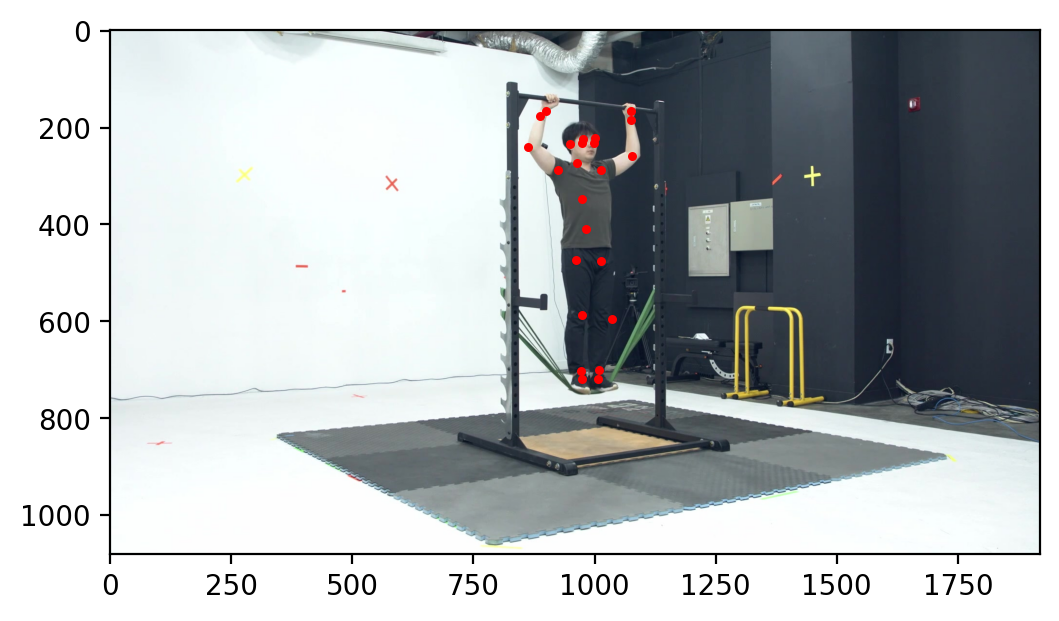

In [19]:

xmin = 500
xmax = 1400
ymin = 100
ymax=1000
def normalize(img, mean, std, max_pixel_value=255.0):
    mean = np.array(mean, dtype=np.float32)
    mean *= max_pixel_value

    std = np.array(std, dtype=np.float32)
    std *= max_pixel_value

    denominator = np.reciprocal(std, dtype=np.float32)

    img = img.astype(np.float32)
    img -= mean
    img *= denominator
    return img

mean = (0.485, 0.456, 0.406)
std = (0.229, 0.224, 0.225)
pixel = 255.0
image = cv2.imread(
    './data/test_imgs/713-3-5-35-Z94_B-0000023.jpg', cv2.COLOR_RGB2BGR)
image=cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
cropped_img = image[ymin:ymax, xmin:xmax,:]
print('croppedimg 모양',cropped_img.shape[0],cropped_img.shape[1])
img = cv2.resize(cropped_img, (288, 384))
img = normalize(img, mean, std, pixel)
img = img.transpose(2, 0, 1)  # 채널, y,x
print('model에 입력되는 이미지',img.shape)
device='cuda' if torch.cuda.is_available() else 'cpu'
img = torch.as_tensor(img, dtype=torch.float32).unsqueeze(dim=0).to(device)
yaml_name = 'w48_384x288_adam_lr1e-3.yaml'
yaml_path = os.path.join('./experiments/coco/hrnet', yaml_name)
model = model_define(yaml_path, True).to(device)
model.load_state_dict(torch.load('./data/best_model.pth'))
model.eval()
preds = model(img)
print('모델에 입력되는 이미지',img.shape)
#preds = get_final_preds(cfg, preds.detach().cpu().numpy())
preds=extract_coordinate(preds)
print(preds.shape)
keypoints = preds.reshape(24,2)
image = cv2.imread(
    './data/test_imgs/713-3-5-35-Z94_B-0000023.jpg', cv2.COLOR_RGB2BGR)
image=cv2.cvtColor(image,cv2.COLOR_RGB2BGR)
print(image.shape)
print(cropped_img.shape[0],cropped_img.shape[1])
keypoints[:, 0] *= (cropped_img.shape[1] /288)
keypoints[:, 1] *= (cropped_img.shape[0] /384)
keypoints[:, 0] += xmin
keypoints[:,1]+=ymin
keypoints = keypoints[:,:2]
fig, ax= plt.subplots(dpi=200)
ax.imshow(image)
ax.scatter(keypoints[:, 0], keypoints[:, 1], s=5, color='r')
plt.show()


In [41]:
!pip3 install detectron2 -f https://dl.fbaipublicfiles.com/detectron2/wheels/cu101/torch1.8/index.html
P

Looking in links: https://dl.fbaipublicfiles.com/detectron2/wheels/cu101/torch1.8/index.html


ERROR: Could not find a version that satisfies the requirement detectron2 (from versions: none)
ERROR: No matching distribution found for detectron2


In [47]:
import sys, os
sys.path.append('..')
import detectron2
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog


dcfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5  # set threshold for this model
# Find a model from detectron2's model zoo. You can use the https://dl.fbaipublicfiles... url as well
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")
predictor = DefaultPredictor(dcfg)


ImportError: cannot import name 'model_zoo' from 'detectron2' (unknown location)

In [36]:
xmin = 500
xmax = 1400
ymin = 100
ymax=1000
from glob import glob
model.load_state_dict(torch.load('./data/save/best_model.pth'))
test_img=sorted(glob('./data/test_imgs/*.jpg'))
df=pd.read_csv('./data/sample_submission.csv')
model.eval()
with torch.no_grad():
  for idx, i in enumerate(test_img):
    image = cv2.imread(i, cv2.COLOR_BGR2RGB)
    
    cropped_img=image[ymin:ymax,xmin:xmax,:]
    image = cv2.resize(cropped_img, (288, 384))
    image = normalize(image,mean,std,pixel)
    image = image.transpose(2, 0, 1)
    image = torch.as_tensor(image, dtype=torch.float32).unsqueeze(dim=0).to(device)
    pred=model(image)
    pred = extract_coordinate(pred)
    keypoints = pred.reshape(24, 2)
 
    keypoints[:, 0] *= cropped_img.shape[1]/288.
    keypoints[:, 1] *= cropped_img.shape[0] / 384.
    keypoints[:, 0] += xmin
    keypoints[:,1]+=ymin
    #--------------------------------------------------------
    '''여기서 추출된 키포인트를 기준으로 한번더 크롭한뒤  '''
    keypoints=keypoints.detach().cpu().numpy()
    Xmin = int(np.min(keypoints[:, 0]))-50
    Xmax = int(np.max(keypoints[:, 0]))+50
    Ymin = int(np.min(keypoints[:, 1]))-50
    Ymax = int(np.max(keypoints[:, 1]))+50
    image2 = cv2.imread(i, cv2.COLOR_BGR2RGB)
    
    crop_img = image2[Ymin:Ymax, Xmin:Xmax,:]
    image2 = cv2.resize(crop_img, (288, 384))
    image2 = normalize(image2, mean, std, pixel)
    image2 = image2.transpose(2, 0, 1)
    image2 = torch.as_tensor(
        image2, dtype=torch.float32).unsqueeze(dim=0).to(device)
    pred = model(image2)
    pred = extract_coordinate(pred)
    keypoints = pred.reshape(24, 2)

    keypoints[:, 0] *= crop_img.shape[1]/288.
    keypoints[:, 1] *= crop_img.shape[0] / 384.
    keypoints[:, 0] += Xmin
    keypoints[:, 1] += Ymin
    keypoints = np.transpose(keypoints)
    #-----------------------------------------------------------
    temp=list()
    for i in range(48):
      if i%2==0:
        temp.append(keypoints[0,i//2])
      else :
        temp.append(keypoints[1,i//2])
    assert len(temp)==48
    temp=np.array(temp)
    df.iloc[idx,1:]=temp
    if idx%100==0:
      print(idx)

df.to_csv('./data/submission_test_3_22.csv', index=False)


0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
